In [1]:
%load_ext rpy2.ipython

/opt/anaconda/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /opt/anaconda/lib/python2.7/argparse.pyc, but /opt/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


In [2]:
%%R
library(plyr); library(dplyr)
library(DESeq2)
library(phyloseq)
library(foreach)
library(doParallel)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector

In [3]:
%%R
physeq = import_biom("../data/otu_table_wtax.biom")

mapfilename = "../data/sample_data_combined_qiime_format.tsv"
QiimeMap <- read.table(file = mapfilename, header = TRUE, 
                       sep = "\t", comment.char = "", 
                       colClasses = c("Density" = "numeric"))
rownames(QiimeMap) <- as.character(QiimeMap[, 1])
sample.data1 = sample_data(QiimeMap)

physeq = merge_phyloseq(physeq,sample.data1)
sample.data2 = sample_data(physeq)
physeq = prune_samples(sample.data2$study == "NSIP", physeq)

In [4]:
%%R

density.min = 1.725

get_Ps = function(physeq.obj, l2fc.threshold, day, sparsity.threshold, test) {
    
    physeq.md = sample_data(physeq.obj)
    p = prune_samples((physeq.md$DayCollected == day)&
                      (physeq.md$Density >= density.min), physeq.obj)
    p.thresh = filter_taxa(p, function(x) sum(x > 0) > (sparsity.threshold * length(x)), TRUE)
    
    dds = phyloseq_to_deseq2(p.thresh, ~Treatment)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")

    r = results(dds, independentFiltering = FALSE)
    beta = r$log2FoldChange
    betaSE = r$lfcSE
    if (test == "greater") {
        p = pnorm(beta, l2fc.threshold, betaSE, lower.tail = FALSE)
    } else if (test == "less") {
        p = pnorm(beta, l2fc.threshold, betaSE, lower.tail = TRUE)
    }
    r$p = p
    DF = data.frame(r[, c("log2FoldChange", "p")])
    
    tax = tax_table(p.thresh)
    if (!setequal(row.names(DF), row.names(tax))) {
        stop("Ordination and supplementary data indices differ on the following:\n",
        setdiff(row.names(DF), row.names(tax)))
    }
    DF = data.frame(DF, tax)
        
    DF$OTU = rownames(DF)
    DF$Day = day
    DF$sparsity.threshold = as.character(sparsity.threshold)
    DF$test = test    
    
    DF
}     

In [5]:
%%R
m = expand.grid(sparsity.threshold = seq(0.05,0.75,0.025), 
                day = c(2, 4), 
                l2fc.threshold = 0.25,
                test = c("greater", "less"))
m

registerDoParallel(10)

df.l2fc = tbl_df(mdply(m, 
                       get_Ps, 
                       .parallel = TRUE, 
                       physeq.obj = physeq))
df.l2fc

Source: local data frame [65,792 x 16]

   day l2fc.threshold log2FoldChange         p      Rank1          Rank2
1    2           0.25      0.3681240 0.4530070 Unassigned             NA
2    2           0.25     -1.4315848 0.9325700   Bacteria    Chloroflexi
3    2           0.25     -1.3856329 0.9394035   Bacteria  Bacteroidetes
4    2           0.25      0.7338556 0.3163615   Bacteria Proteobacteria
5    2           0.25     -0.5806152 0.7968392   Bacteria    Chloroflexi
6    2           0.25     -1.2414574 0.9261187   Bacteria Proteobacteria
7    2           0.25      0.6747027 0.3380584 Unassigned             NA
8    2           0.25     -0.2689453 0.6785073   Bacteria Proteobacteria
9    2           0.25     -0.1357915 0.6428777   Bacteria Actinobacteria
10   2           0.25     -2.1668860 0.9872945   Bacteria Proteobacteria
.. ...            ...            ...       ...        ...            ...
Variables not shown: Rank3 (fctr), Rank4 (fctr), Rank5 (fctr), Rank6 (fctr),
  Rank7

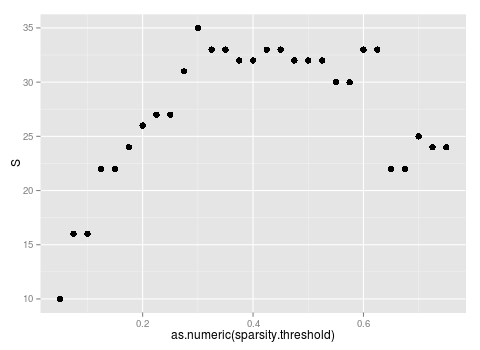

In [7]:
%%R -h 350
FDR = 0.10

d = df.l2fc %>%
    filter(test == "greater") %>%
    group_by(sparsity.threshold) %>%
    mutate(p.adj = p.adjust(p, "BH"))  %>%
    dplyr::summarize(S = sum(p.adj <= FDR))

p = ggplot(d, aes(x = as.numeric(sparsity.threshold), y = S)) + geom_point(size = 3)

p

In [8]:
%%R
df.l2fc.xindepfilt = df.l2fc %.%
                    filter(sparsity.threshold == "0.3")

df.l2fc.padj = df.l2fc.indepfilt %>% 
                filter(test == "greater") %>%
                mutate(p.adj = p.adjust(p, method = "BH")) %>%
                select(p.adj, OTU, Day, test)

df.l2fc.indepfilt = left_join(df.l2fc.indepfilt, df.l2fc.padj)

Joining by: c("OTU", "Day", "test")


In [9]:
%%R
write.csv(df.l2fc.indepfilt, "../data/l2fc_table.csv", row.names = FALSE)

In [10]:
%%R
sessionInfo()

R version 3.1.2 (2014-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ggplot2_1.0.0           doParallel_1.0.8        iterators_1.0.7        
 [4] foreach_1.4.2           phyloseq_1.10.0         DESeq2_1.6.1           
 [7] RcppArmadillo_0.4.500.0 Rcpp_0.11.3             GenomicRanges_1.18.1   
[10] GenomeInfoDb_1.2.2      IRanges_2.0.0           S4Vectors_0.4.0        
[13] BiocGenerics_0.12.0     dplyr_0.3.0.2           plyr_1.8.1             

loaded via a namespace